In [16]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [17]:
from __future__ import division
from deltasigma import *
import warnings
from scipy.signal import ss2zpk
warnings.filterwarnings('ignore')

Example continuous-time lowpass modulator - dsexample #3
========================================================

Demonstration of a low-pass, 3rd-order continuous-time delta sigma modulator, in a very similar fashion as as done in the **MATLAB Delta Sigma Toolbox**, albeit employing the Python port of the MATLAB package, **`deltasigma`**.


 * The **Noise Transfer Function** (NTF) is synthesized for a **3th-order**, **low-pass** modulator.
 * Time domain simulations are then performed to **extract the SNR**.
 * The continuous-time NTF is realized and mapped to an **equivalent discrete-time structure**.
 * The SNQR is again assessed.
 * The modulator coefficients are then **scaled** and the final results are presented.

##General modulator parameters

In [18]:
order = 3
osr = 32
nlev = 2
f0 = 0.
Hinf = 1.5
tdac = [0, 1]
form = 'FB'
M = nlev - 1
#generic options
plotsize = (15, 8) #inches

## Synthesis

In [19]:
ntf0 = synthesizeNTF(order, osr, 2, Hinf, f0) # 2: Optimized zero placement
for z, p in zip(ntf0[0], ntf0[1]):
    print ("(%f, %fj)\t(%f, %fj)" % (np.real(z), np.imag(z), np.real(p), np.imag(p)))


(1.000000, 0.000000j)	(0.764515, -0.280052j)
(0.997110, 0.075973j)	(0.764515, 0.280052j)
(0.997110, -0.075973j)	(0.668460, 0.000000j)


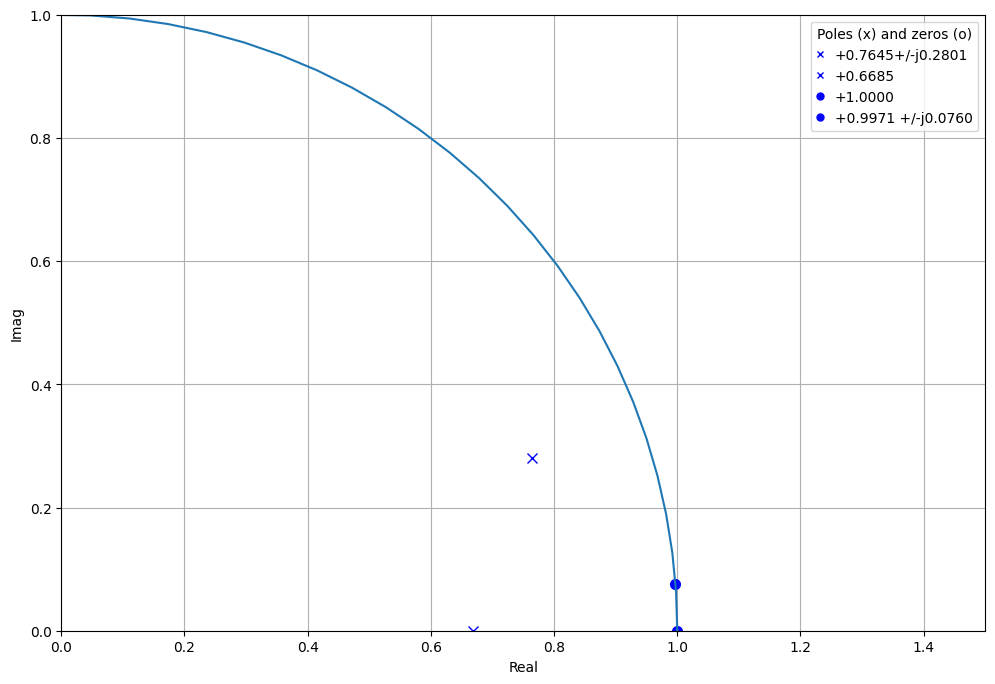

In [20]:
figure(figsize=plotsize)
plotPZ(ntf0, showlist=True)
changeFig(10, 1.5, 7)

<Figure size 1500x800 with 0 Axes>

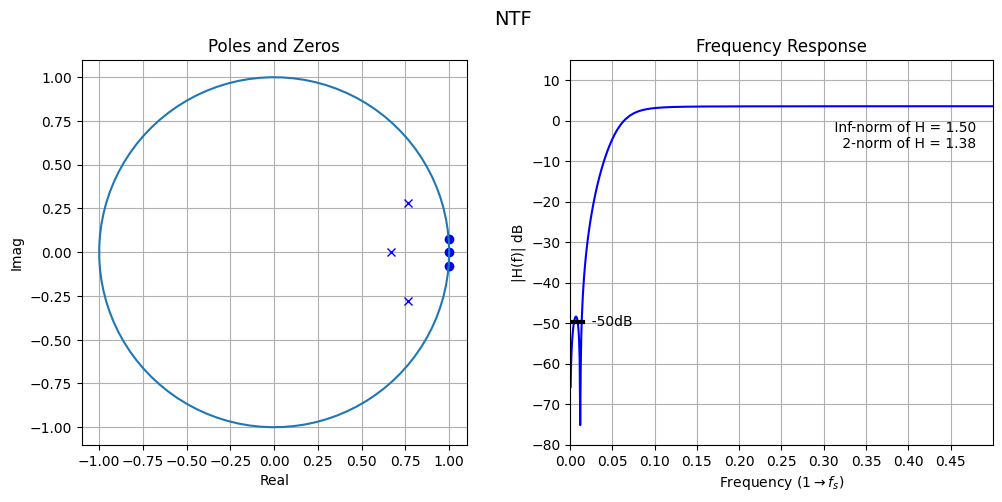

In [21]:
figure(figsize=plotsize)
DocumentNTF(ntf0, osr, f0)

##Time-domain NTF simulation

Doing time-domain simulations...


Text(0.5, 1.0, 'Example Spectrum')

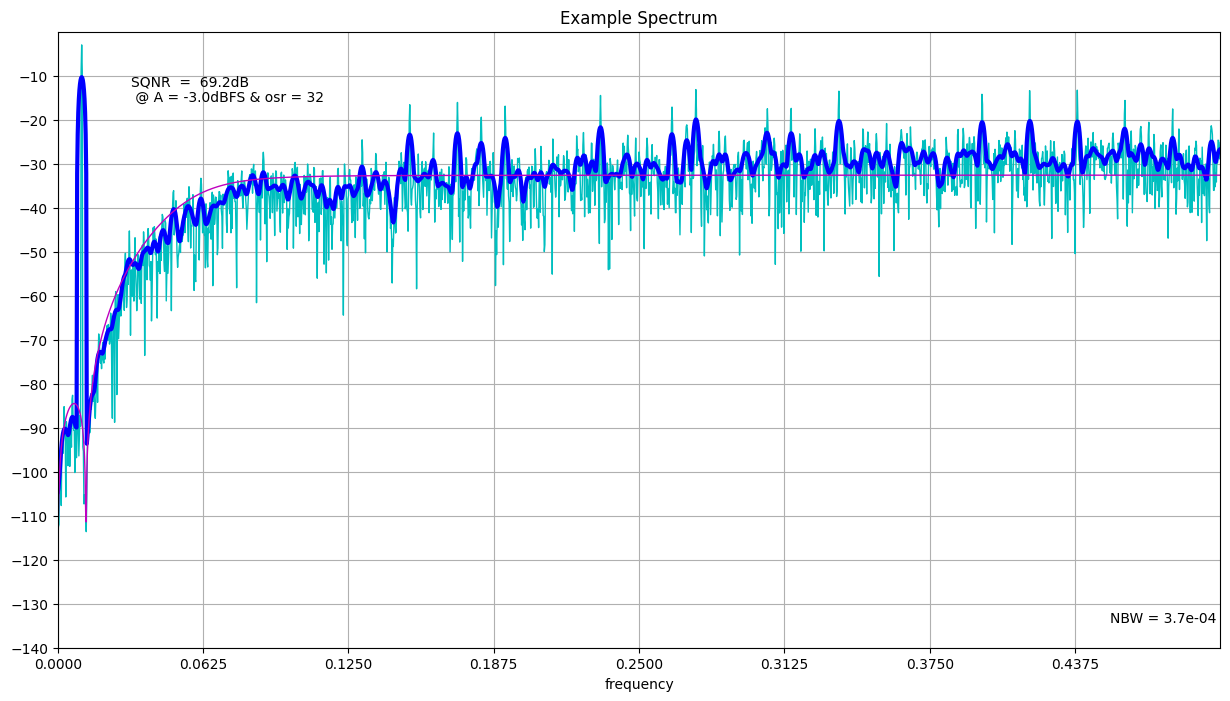

In [22]:
print ('Doing time-domain simulations...')
figure(figsize=plotsize)
PlotExampleSpectrum(ntf0, M, osr, f0)
title('Example Spectrum')

##Signal to Noise Ratio

If we have a two level quantizer, we run the prediction routine `predictSNR`, which employs the describing function method of Ardalan and Paulos.

Otherwise, we skip the prediction step and we move directly to time simulation of the NTF, to evaluate the SNR.

In [23]:
if nlev == 2:
    snr_pred, amp_pred, k0, k1, se = predictSNR(ntf0, osr)
snr, amp = simulateSNR(ntf0, osr, None, f0, nlev)

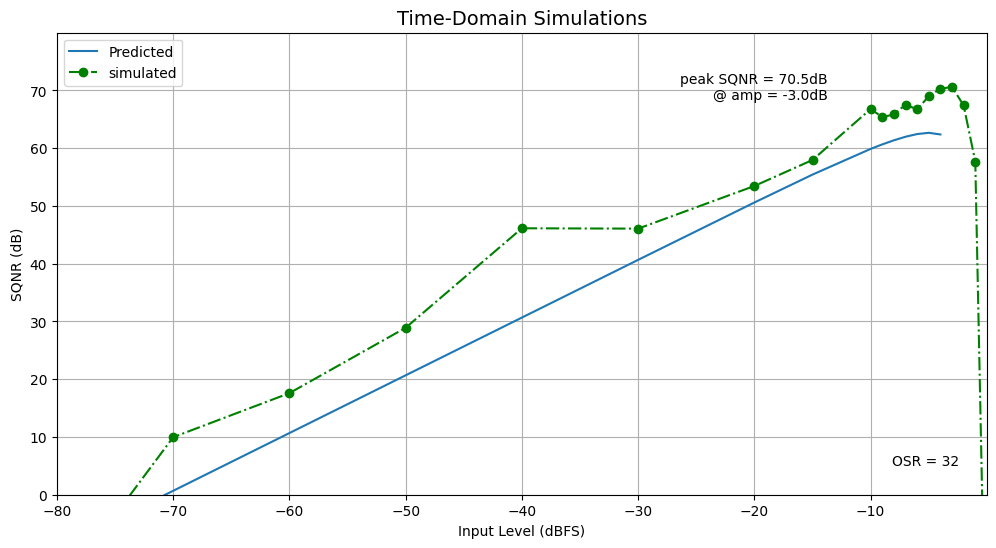

In [27]:
figure(figsize=plotsize)
if nlev == 2:
    plot(amp_pred, snr_pred, '-', label='Predicted')
    # plt.hold(True)
plot(amp, snr,'o-.g', label='simulated')
#figureMagic(np.array([- 100,0]).reshape(1,-1),10,2,np.array([0,100]).reshape(1,-1),10,2,np.array([7,3]).reshape(1,-1),'Discrete-Time Simulation')
xlabel('Input Level (dBFS)')
ylabel('SQNR (dB)')
peak_snr, peak_amp = peakSNR(snr, amp)
msg = 'peak SQNR = %4.1fdB  \n@ amp = %4.1fdB  ' % (peak_snr, peak_amp)
text(peak_amp-10, peak_snr, msg, horizontalalignment='right', verticalalignment='center');
msg = 'OSR = %d ' % osr
plt.text(-2, 5, msg, horizontalalignment='right');
# plt.hold(False)
figureMagic([-80, 0], 10, None, [0, 80], 10, None, [12, 6], 'Time-Domain Simulations')
legend(loc=2);

## Realize the NTF and map it to an equivalent discrete-time structure

Performed in two steps:

 * We call `realizeNTF_ct` to realize an NTF with a continuous-time loop filter, obtaining ABCD matrix and DAC timings. 

 * We map the synthesized NTF to a discrete-time equivalent. The criterion for equivalence is set in `mapCtoD`: the sampled pulse response of the CT system must be identical to the impulse response of the DT system.

In [ ]:
print('Mapping to continuous-time... ')
ABCDc, tdac2 = realizeNTF_ct(ntf0, form, tdac)
Ac, Bc, Cc, Dc = partitionABCD(ABCDc)
sys_c = []
for i in range(Bc.shape[1]):
    sys_c.append(ss2zpk(Ac, Bc, Cc, Dc, input=i))
print('done.')
print('ABCD matrix:')
print(ABCDc)
print("DAC timing (tdac2):")
print(tdac2)

Mapping to continuous-time... 
done.
ABCD matrix:
[[ 0.          0.          0.          0.04440878 -0.04440878]
 [ 1.          0.         -0.00578297  0.         -0.23997613]
 [ 0.          1.          0.          0.         -0.67004645]
 [ 0.          0.          1.          0.          0.        ]]
DAC timing (tdac2):
[[-1. -1.]
 [ 0.  1.]]


TypeError: 'float' object cannot be interpreted as an integer

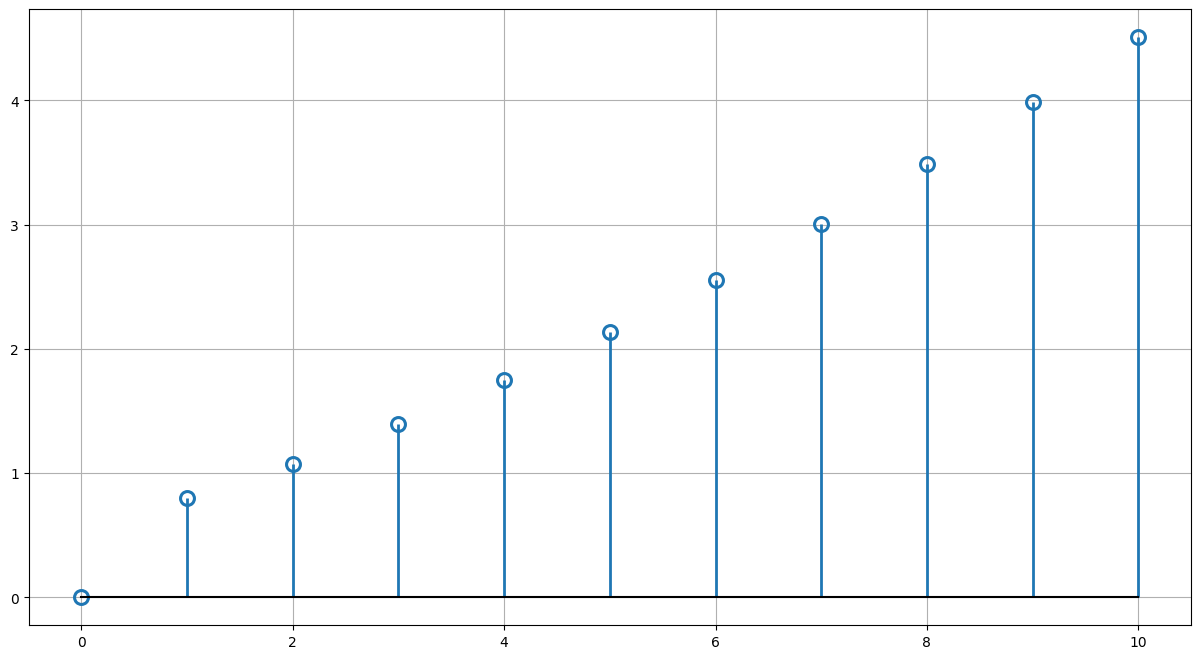

In [28]:
figure(figsize=plotsize)
n_imp = 10
y = -impL1(ntf0, n_imp)
lollipop(np.arange(n_imp + 1), y)
# hold(True)
grid(True)
dt = 1./16
tppulse = np.vstack((np.zeros((1, 2)), tdac2[1:, :])).tolist()
yy = -pulse(sys_c, tppulse, dt, n_imp).squeeze()
t = np.linspace(0, n_imp + dt, 10/dt + 1)
plot(t, yy, 'g', label='continuous-time')
legend()
title('Loop filter pulse/impulse responses (negated)');

<Figure size 1500x800 with 0 Axes>

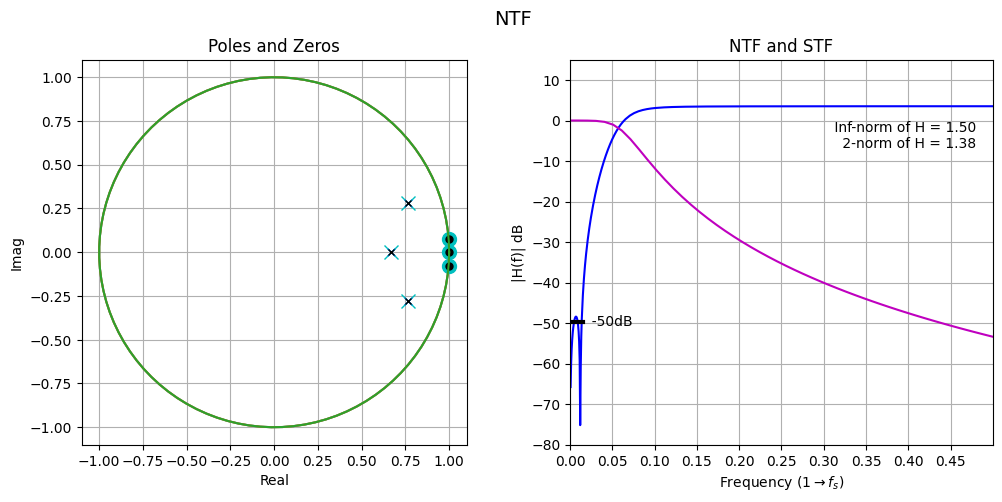

In [29]:
sys_d, Gp = mapCtoD(ABCDc, tdac2)
ABCD = np.vstack((
                  np.hstack((sys_d[0], sys_d[1])),
                  np.hstack((sys_d[2], sys_d[3]))
                ))
ntf, G = calculateTF(ABCD)
ntf = cancelPZ(ntf)
figure(figsize=plotsize)
DocumentNTF(ntf0, osr, f0)
subplot(121)
plotPZ(ntf, 'c', 10)
# hold(True)
plotPZ(ntf0, 'k')
# hold(False)

L0 = sys_c[0]
f = linspace(0, 0.5)
G = evalTFP(L0, ntf, f)
subplot(122)
# hold(True)
plot(f, dbv(G), 'm')
# hold(False)
title('NTF and STF');

In [31]:
print('Re-evaluating the SNR... ', end='')
snrR, ampR = simulateSNR(ABCD, osr, None, f0, nlev)
print('done')

Re-evaluating the SNR... done


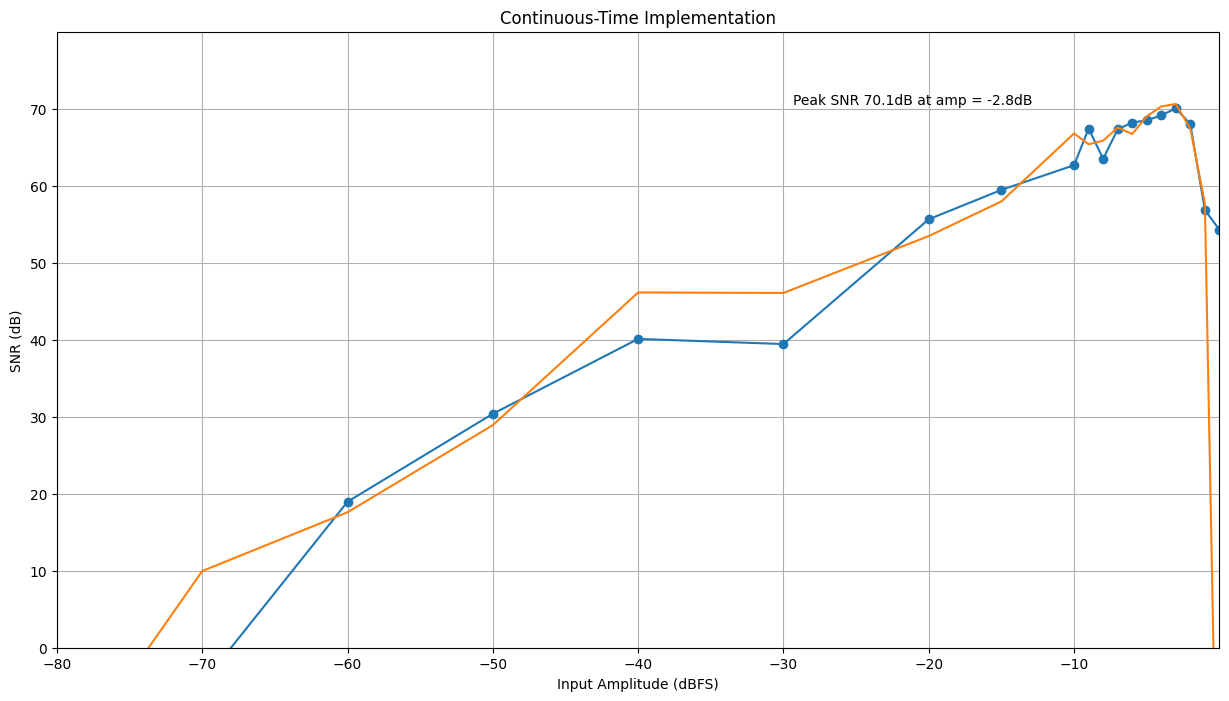

In [32]:
figure(figsize=plotsize)
plot(ampR, snrR, 'o-')
# hold(True)
plot(amp, snr, '-')
peak_snrR, peak_ampR = peakSNR(snrR, ampR)
msg = 'Peak SNR %.1fdB at amp = %-.1fdB' % (peak_snrR, peak_ampR)
text(peak_ampR - 10, peak_snrR, msg, horizontalalignment='right', verticalalignment='bottom');
figureMagic([-80, 0], 10, 1, [0, 80], 10, 1, None,'SQNR vs. Input Amplitude')
xlabel('Input Amplitude (dBFS)')
ylabel('SNR (dB)')
title('Continuous-Time Implementation');

## Dynamic range scaling

In [34]:
print('Doing dynamic range scaling... ', end='')
ABCDs, umax, S = scaleABCD(ABCD, nlev, f0, 1, None, None, 10000.0)
S = S[:order, :order]
Sinv = inv(S)
Acs = np.dot(np.dot(S, Ac), Sinv)
Bcs = np.dot(S, Bc)
Ccs = np.dot(Cc, Sinv)
ABCDcs = np.vstack((np.hstack((Acs, Bcs)),
                    np.hstack((Ccs, Dc))
                  ))
sys_cs = (Acs, Bcs, Ccs, Dc)
print('Done.')
print("During scaling, umax was found to be %g" % umax)
print("Scaled ABCD matrix:")
print(ABCDcs)

Doing dynamic range scaling... Done.
During scaling, umax was found to be 0.78
Scaled ABCD matrix:
[[ 0.          0.          0.          0.16352917 -0.16352917]
 [ 0.2996815   0.         -0.01756679  0.         -0.26482216]
 [ 0.          0.32919918  0.          0.         -0.24341646]
 [ 0.          0.          2.75267518  0.          0.        ]]


##Conclusions: synthesis results

The ADC parameters were found to be:

In [36]:
adc = {
    'order': order,
    'osr': osr,
    'M': M,
    'f0': f0,
    'ntf': ntf,
    'ABCD': ABCD,
    'umax': umax,
    'peak_snr': peak_snr,
    'form': form,
    'ABCDc': ABCDc,
    'tdac': tdac,
    'tdac2': tdac2,
    'L0': L0,
    'sys_c': sys_c,
    'ABCDcs': ABCDcs,
    'sys_cs': sys_cs
}
for k in sorted(adc.keys()):
    print("%s:" % k, end=' ')
    if str(adc[k]).count('\n'):
        print("")
    print(adc[k])

ABCD: 
[[ 1.          0.          0.          0.04440878 -0.04440878]
 [ 0.99903645  0.99710991 -0.0057774   0.02219369 -0.2600021 ]
 [ 0.49975909  0.99903645  0.99710991  0.00739932 -0.7967304 ]
 [ 0.          0.          1.          0.          0.        ]]
ABCDc: 
[[ 0.          0.          0.          0.04440878 -0.04440878]
 [ 1.          0.         -0.00578297  0.         -0.23997613]
 [ 0.          1.          0.          0.         -0.67004645]
 [ 0.          0.          1.          0.          0.        ]]
ABCDcs: 
[[ 0.          0.          0.          0.16352917 -0.16352917]
 [ 0.2996815   0.         -0.01756679  0.         -0.26482216]
 [ 0.          0.32919918  0.          0.         -0.24341646]
 [ 0.          0.          2.75267518  0.          0.        ]]
L0: (array([], dtype=float64), array([-0.+0.07604585j,  0.-0.07604585j,  0.+0.j        ]), np.float64(0.044408783846876895))
M: 1
f0: 0.0
form: FB
ntf: 
(array([0.99710991-0.07597258j, 0.99710991+0.07597258j,
       1

### System version information

In [37]:
#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information

%version_information numpy, scipy, matplotlib, deltasigma

ModuleNotFoundError: No module named 'version_information'